In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras, config
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from sklearn.metrics import classification_report

In [2]:
def TrainData():
    fake_img = r"archive\train\FAKE"
    real_img = r"archive\train\REAL"
    gan_img = r"GAN\train"
    train_img = []
    train_label = []

    random_fake = np.random.choice(os.listdir(fake_img), 25000, replace=False)
    random_real = np.random.choice(os.listdir(real_img), 25000, replace=False)

    for p in tqdm(random_fake, desc='Fake Training Data from CIFAKE'):
        train_img.append(os.path.join(fake_img, p))
        train_label.append('AI')
    for p in tqdm(os.listdir(gan_img), desc='Fake Training Data generated by DCGAN'):
        train_img.append(os.path.join(gan_img, p))
        train_label.append('GAN')
    for p in tqdm(random_real, desc='Real Training Data'):
        train_img.append(os.path.join(real_img, p))
        train_label.append('Real')
    
    print(f'{len(train_label)} training images loaded.')
    train_img = pd.Series(train_img, name="path")
    train_label = pd.Series(train_label, name="labels")
    train_data = pd.concat([train_img, train_label], axis=1)
    
    return train_data

In [3]:
def TestData():
    fake_img = r"archive\test\FAKE"
    real_img = r"archive\test\REAL"
    gan_img = r"GAN\test"
    test_img = []
    test_label = []

    for p in tqdm(os.listdir(fake_img), desc='Fake Testing Data'):
        test_img.append(os.path.join(fake_img, p))
        test_label.append('AI')
    for p in tqdm(os.listdir(gan_img), desc='Fake Training Data generated by DCGAN'):
        test_img.append(os.path.join(gan_img, p))
        test_label.append('GAN')
    for p in tqdm(os.listdir(real_img), desc='Real Testing Data'):
        test_img.append(os.path.join(real_img, p))
        test_label.append('Real')
    
    test_img = pd.Series(test_img, name="path")
    test_label = pd.Series(test_label, name="labels")
    test_data = pd.concat([test_img, test_label], axis=1)
    print('25000 testing images loaded.')
    
    return test_data

In [4]:
def ImageGen(train_data, test_data):
    gen1 = ImageDataGenerator(
        # rescale=1/255,
        rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True,
    )

    gen2 = ImageDataGenerator(
        # rescale=1/255,
    )

    train_gen = gen1.flow_from_dataframe(
        train_data, 
        x_col='path', 
        y_col='labels', 
        target_size=(32, 32), 
        class_mode= 'categorical', 
        color_mode='rgb', 
        shuffle=True, 
        batch_size=200
    )

    test_gen = gen2.flow_from_dataframe(
        test_data,
        x_col='path', 
        y_col='labels', 
        target_size=(32, 32), 
        class_mode= 'categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=200
    )

    return train_gen, test_gen

In [5]:
def Built_Model():
    base_model = keras.applications.EfficientNetV2B3(
        include_top=False, 
        weights="imagenet", 
        input_shape=(32, 32, 3), 
        pooling='max'
    )
    base_model.trainable = True

    x = base_model.output
    x = BatchNormalization()(x)
    x = Dense(
        256,
        kernel_regularizer = keras.regularizers.l2(l=0.016), 
        activity_regularizer = keras.regularizers.l1(0.006), 
        bias_regularizer = keras.regularizers.l1(0.006), 
        activation='relu'
    )(x)
    x = Dropout(rate=0.4, seed=123)(x) 

    output = Dense(3, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=output)

    model.compile(keras.optimizers.Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [6]:
train_data = TrainData()
test_data = TestData()

Real Training Data: 100%|██████████| 25000/25000 [00:00<00:00, 499907.51it/s]


60000 training images loaded.


Real Testing Data: 100%|██████████| 10000/10000 [00:00<00:00, 618857.10it/s]

25000 testing images loaded.


In [7]:
"""
Tensorflow supports running computations on GPU 

WARNING : You need to have CUDA, cuDNN, and tensorflow with version lower than 2.11.0, 
          if not, DON'T execute this cell.
"""
physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print('Running on GPU available now')

Running on GPU available now


In [8]:
train_data, test_data = ImageGen(train_data, test_data)

Found 60000 validated image filenames belonging to 3 classes.
Found 25000 validated image filenames belonging to 3 classes.


In [9]:
model = Built_Model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 16, 16, 40)   1080        ['normalization[0][0]']          
                                                                                              

In [10]:
history = model.fit(train_data, steps_per_epoch=len(train_data), epochs=20, validation_data=test_data)

Epoch 1/20
300/300 [==============================] - 188s 582ms/step - loss: 3.3173 - accuracy: 0.8135 - val_loss: 1.1974 - val_accuracy: 0.8831
Epoch 2/20
300/300 [==============================] - 43s 142ms/step - loss: 0.6749 - accuracy: 0.9247 - val_loss: 0.4361 - val_accuracy: 0.9134
Epoch 3/20
300/300 [==============================] - 42s 141ms/step - loss: 0.3233 - accuracy: 0.9410 - val_loss: 0.4059 - val_accuracy: 0.8900
Epoch 4/20
300/300 [==============================] - 45s 150ms/step - loss: 0.2514 - accuracy: 0.9484 - val_loss: 0.2370 - val_accuracy: 0.9449
Epoch 5/20
300/300 [==============================] - 44s 148ms/step - loss: 0.2220 - accuracy: 0.9538 - val_loss: 0.2166 - val_accuracy: 0.9505
Epoch 6/20
300/300 [==============================] - 46s 153ms/step - loss: 0.2041 - accuracy: 0.9572 - val_loss: 0.2599 - val_accuracy: 0.9287
Epoch 7/20
300/300 [==============================] - 44s 146ms/step - loss: 0.1820 - accuracy: 0.9625 - val_loss: 0.1821 - val_a

In [11]:
pred = model.predict(test_data)
predicted = [(np.argmax(i)) for i in pred]

125/125 [==============================] - 9s 55ms/step


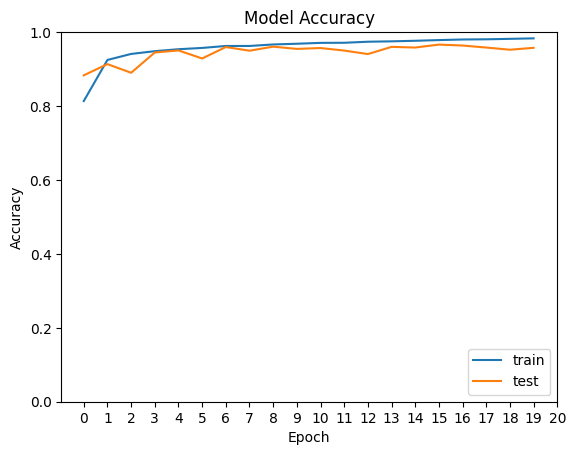

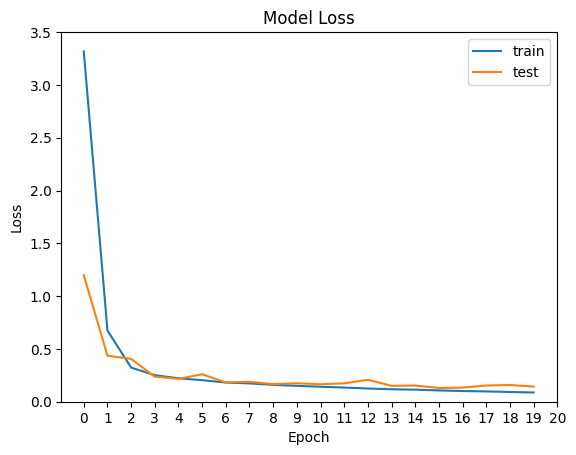

In [12]:
# Plot the loss and accuracy of training set.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(range(0, 21, 1))
plt.ylim(0, 1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0, 21, 1))
plt.ylim(0, 3.5)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
print('\nClassification Report:\n----------------------\n', classification_report(np.array(test_data.labels), predicted))


Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     10000
           1       1.00      1.00      1.00      5000
           2       0.99      0.90      0.94     10000

    accuracy                           0.96     25000
   macro avg       0.97      0.96      0.96     25000
weighted avg       0.96      0.96      0.96     25000



In [14]:
# Model saved
model.save('Models/EfficientNet_improved.h5')